# Тестовое задание для кандидата в команду валидации Альфа-Банка

**Привет!** На связи команда валидации Альфа-Банка. Мы отвечаем за то, чтобы модели, которые используются для принятия решений, были надежными, справедливыми и понятными. Твое задание — провести моделирование и валидацию кредитной модели. Удачи, и помни: мы верим в твои силы! 💪  

---

## Цель  
Проверить навыки анализа данных, валидации ML-моделей и умение формулировать выводы для бизнеса.  

---

## Датасет  
**Название:** [Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/data)  
**Описание:**  
Прогнозирование дефолта заемщика на основе финансовых и демографических признаков.  

**Признаки:**  
- `RevolvingUtilizationOfUnsecuredLines` (использование кредитных линий),  
- `age`, `MonthlyIncome`, `NumberOfDependents` и др.  

**Целевая переменная:** `SeriousDlqin2yrs` (дефолт: 0/1).  

---

## Задача  
Проведите валидацию модели кредитного скоринга (логистическая регрессия или градиентный бустинг) и подготовьте отчет.  

---

## Шаги  

### 1. Анализ и предобработка данных  
- Обработайте пропуски (например, в `MonthlyIncome`).  
- Исследуйте выбросы (например, возраст < 18 лет).  
- Визуализируйте распределения ключевых признаков.  
- Предложите методы борьбы с дисбалансом классов.  

### 2. Построение и оценка модели  
- Разделите данные на train/validation/test.  
- Обучите модель (логистическая регрессия или CatBoost/XGBoost).  
- Рассчитайте метрики: **AUC-ROC, Precision, Recall, F1-Score**.  
- Проверьте устойчивость модели через кросс-валидацию (5 folds).  

### 3. Интерпретация и этика  
- Выделите **топ-5 признаков**, влияющих на прогноз (SHAP/LIME).  
- Проверьте логичность влияния признаков (например, высокая долговая нагрузка → выше риск дефолта).  
- Оцените fairness модели: сравните метрики (FPR, TPR) для групп (например, **молодые** vs **старше 40 лет**).  

### 4. Отчет  
Подготовьте общие выводы по проведенной валидации, включив:  
- Выводы о качестве модели и её ограничениях.  
- Рекомендации по улучшению (например, сбор дополнительных данных).  
- Пример: *«Как изменится прогноз, если у заемщика появится иждивенец?»*  

---

## Технические требования  
- Язык: **Python** (Jupyter Notebook).  
- Код должен быть читаемым и содержать комментарии.  

---

## Критерии оценки  
1. Глубина анализа данных и обработки выбросов.  
2. Корректность выбранных метрик и их интерпретация.  
3. Качество визуализаций (распределения, важность признаков).  
4. Практичность рекомендаций в отчете.    

---

**Срок выполнения:** 7 дней.  
**Формат сдачи:**  
- Ноутбук в Collab/GitHub-репозиторий.    

---

Это задание покажет, как вы подходите к анализу реальных данных и делаете ML-модели прозрачными для бизнеса. Ждем твою работу! 🚀

### 0. Введение и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats.mstats import winsorize
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from xgboost import XGBClassifier

In [2]:
# Loading data
train_df = pd.read_csv('data/cs-training.csv', index_col=0)
print("Train shape:", train_df.shape)
train_df.head()

Train shape: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# Check features
dict_df = pd.read_excel('data/Data Dictionary.xls', header=1)
display(dict_df)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


### 1. Анализ и предобработка данных

#### 1.1.   Обработка пропусков
Сбросим дубликаты, чтобы последующее заполнение пропусков не сказалось на точности

In [4]:
print(f'Number of duplicates: {train_df.duplicated().sum()}')
train_df = train_df.drop_duplicates()

Number of duplicates: 609


In [5]:
# Missing
missing_data = train_df.isna().sum()
missing_percent = (missing_data / train_df.shape[0]) * 100
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Missing Percent': missing_percent})
display(missing_df)

,Missing Count,Missing Percent
SeriousDlqin2yrs,0,0.000000
RevolvingUtilizationOfUnsecuredLines,0,0.000000
age,0,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0,0.000000
DebtRatio,0,0.000000
MonthlyIncome,29221,19.560081
NumberOfOpenCreditLinesAndLoans,0,0.000000
NumberOfTimes90DaysLate,0,0.000000
NumberRealEstateLoansOrLines,0,0.000000
NumberOfTime60-89DaysPastDueNotWorse,0,0.000000


Видим пропуски в данных в столбце `MonthlyIncome` (ежемесячный доход) и `NumberOfDependents` (количество иждивенцев), посмотрим на их распределение

In [6]:
train_df['income_group'] = train_df['NumberOfDependents'].isna().map({False: 'normal', True: 'missing'})

In [7]:
train_df.groupby('income_group')['MonthlyIncome'].describe()

,count,mean,std,min,25%,50%,75%,max
income_group,,,,,,,,
missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
normal,120170.0,6675.098269,14389.582246,0.0,3400.0,5400.0,8250.0,3008750.0


<Figure size 800x500 with 0 Axes>

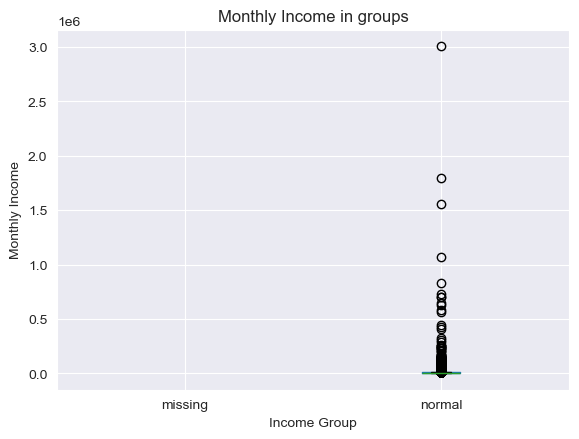

In [8]:
plt.figure(figsize=(8, 5))
train_df.boxplot(column='MonthlyIncome', by='income_group')
plt.ylabel('Monthly Income')
plt.xlabel('Income Group')
plt.title('Monthly Income in groups')
plt.suptitle('')
plt.show()

Пропуски в `MonthlyIncome` распределены не случайно: часть строк вообще не указала `NumberOfDependents`, а часть — указала. При этом доходы в этих двух группах ведут себя по-разному, и стандартная «медиана по всему датасету» - не подходит.

Группа с известным числом иждивенцев (normal) — «нормальные» наблюдения, медиану MonthlyIncome в рамках этой группы использовать безопасно.

Группа без данных об иждивенцах (missing) - аномальные или неполные записи, где сразу два важных поля отсутствуют, поэтому заполним 0.

In [9]:
# Fill in the median in rows with a known number of dependents
median_income_with_dependents = train_df.loc[train_df['NumberOfDependents'].notna(), 'MonthlyIncome'].median()
known_dep_missing = (train_df['NumberOfDependents'].notna() & train_df['MonthlyIncome'].isna())
train_df.loc[known_dep_missing, 'MonthlyIncome'] = median_income_with_dependents

# Fill in 0 in the rows with NaN in both columns
unknown_dep_missing = (train_df['NumberOfDependents'].isna() & train_df['MonthlyIncome'].isna())
train_df.loc[unknown_dep_missing, 'MonthlyIncome'] = 0

# Filling in NumberOfDependents with NaN
train_df['NumberOfDependents'] = train_df['NumberOfDependents'].fillna(0)
train_df.drop('income_group', axis=1, inplace=True)

In [10]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtypes: fl

None

#### 1.2.   Проверим данные на выбросы

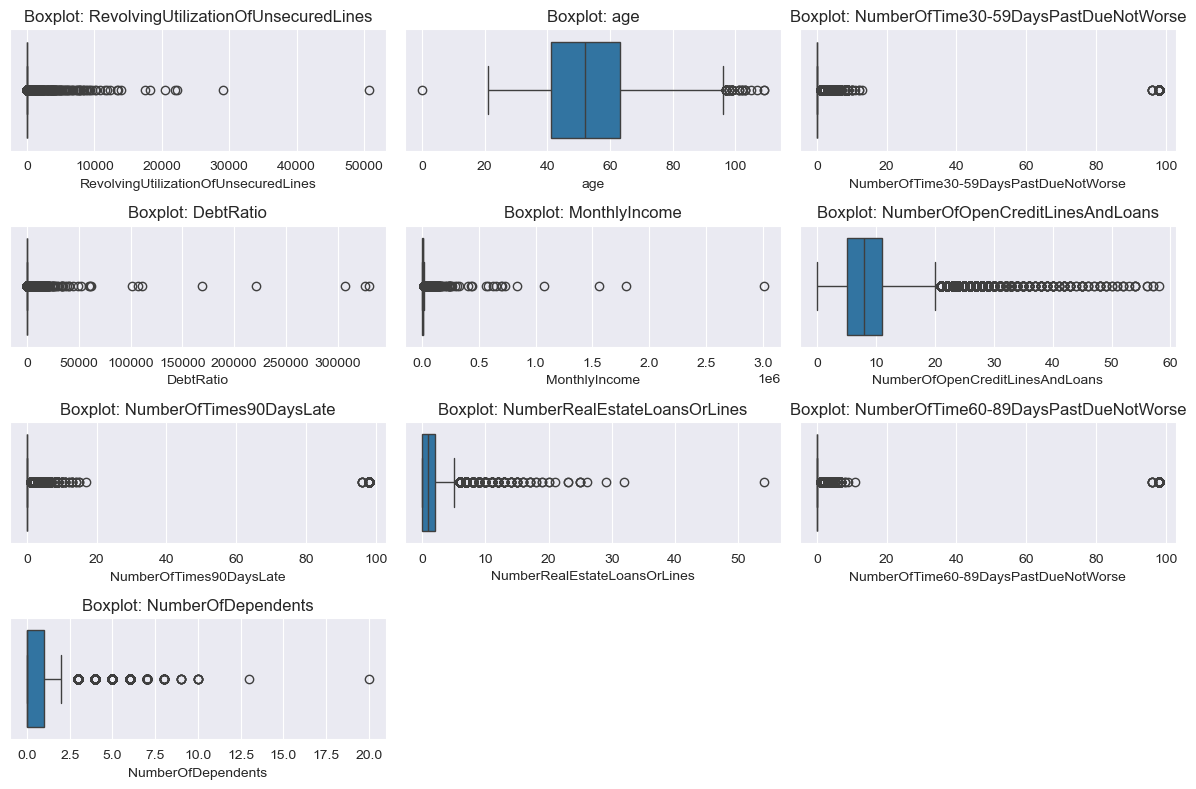

In [11]:
plt.figure(figsize=(12, 8))
for i, col in enumerate([col for col in train_df.columns if col != 'SeriousDlqin2yrs']):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=train_df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

`RevolvingUtilizationOfUnsecuredLines` - очень сильная правая скошенность (много наблюдений около 0), выбросы вплоть до 50 000.

`age` - большинство клиентов в диапазоне \~25–70 лет, но есть «выбросы» < 18 и > 100.

`DebtRatio` - плотность вблизи 0–1, но единичные экстремумы до > 300 000.

`MonthlyIncome` - сильно скошено вправо, выбросы до > 3 млн.

`NumberRealEstateLoansOrLines` - много клиентов без недвижимости (0), затем убывающая экспоненциально частота вплоть до \~55.

`NumberOfOpenCreditLinesAndLoans` - почти нормальное распределение вокруг \~10, но есть выбросы до \~60.

`NumberOfTime30-59DaysPastDueNotWorse` - большинство — 0, но есть редкие значения до \~100 (скорее всего, кодовые или ошибочные).

`NumberOfTime60-89DaysPastDueNotWorse` - аналогично 30–59 дней: почти все нули, редкие «выбросы» до \~100.

`NumberOfTimes90DaysLate` - почти все нули, редкие единичные случаи и «выбросы» до 100.

`NumberOfDependents` - большинство 0–2, редкие случаи до 20.

---
**Итоговая схема предобработки**

1. **Винсоризация (обрезка выбросов)** по разумным бизнес-пределам (30–59, 60–89, 90+ days, NumberOfDependents).
2. **Лог-трансформации** для сильно скошенных (RevolvingUtilization, DebtRatio, MonthlyIncome).
3. **Корректировка** нереалистичных значений (age).


In [12]:
# Winsonization
winsor_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfDependents',
]

for col in winsor_cols:
    train_df[col] = winsorize(train_df[col], (0.01, 0.01))

In [13]:
# Log transformation for strongly skewed features
log_cols = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome'
]

for col in log_cols:
    train_df[col] = np.log1p(train_df[col])

In [14]:
# Age adjustment
valid_age = train_df['age'].between(18, 95)
median_age = train_df.loc[valid_age, 'age'].median()
train_df.loc[~valid_age, 'age'] = median_age

#### 1.3.   Визуализируем распределение признаков

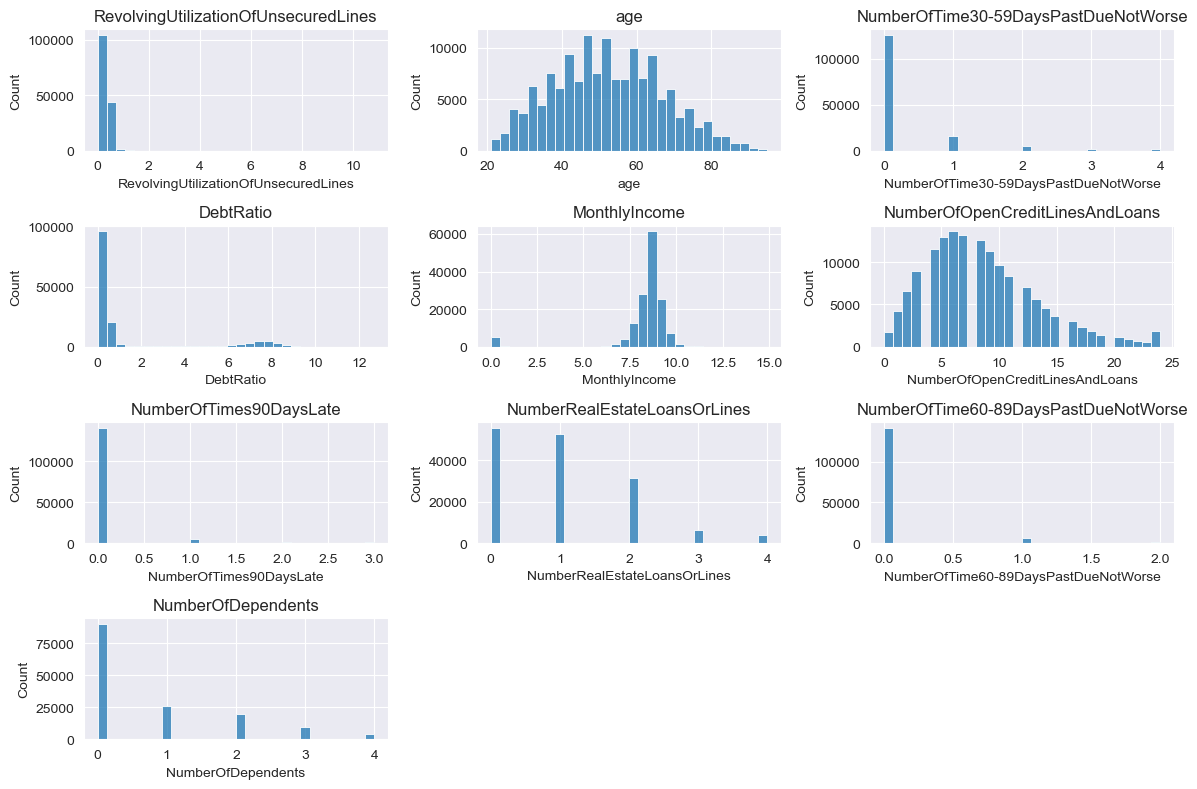

In [15]:
plt.figure(figsize=(12, 8))
for i, col in enumerate([col for col in train_df.columns if col != 'SeriousDlqin2yrs']):
    plt.subplot(4, 3, i + 1)
    sns.histplot(train_df[col].dropna(), kde=False, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

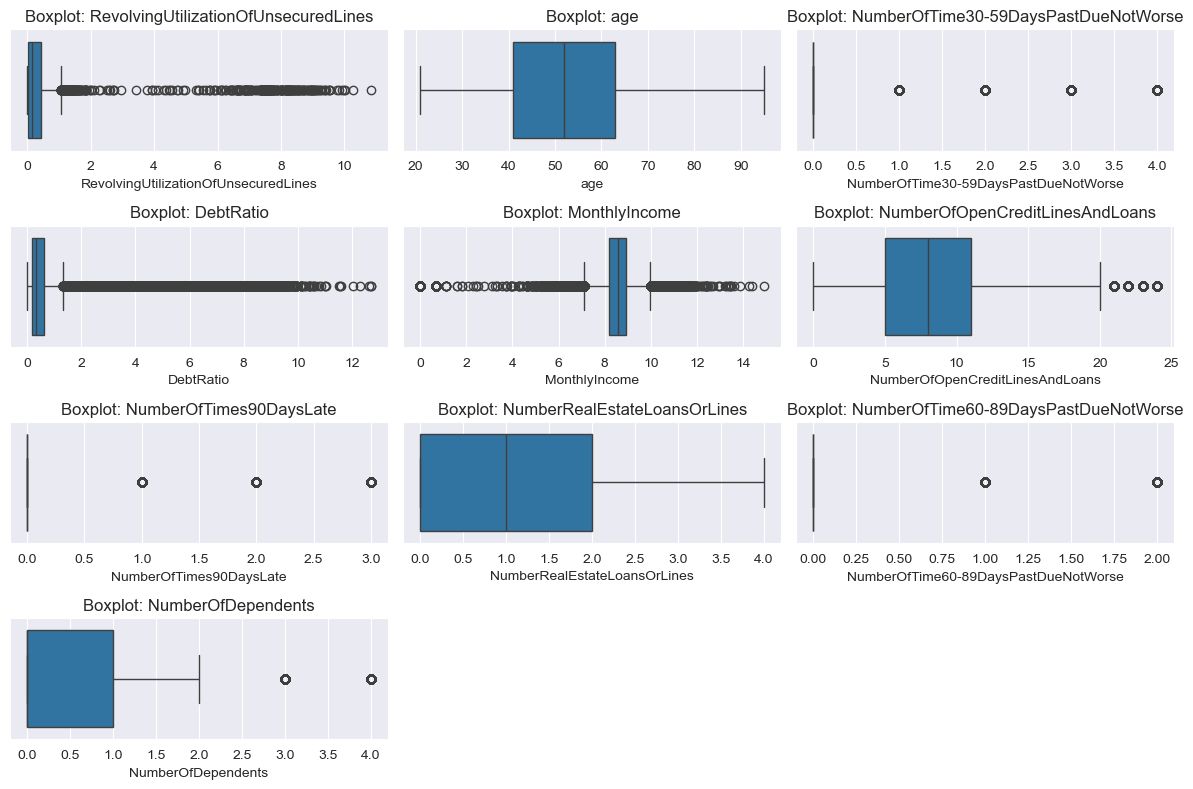

In [16]:
plt.figure(figsize=(12, 8))
for i, col in enumerate([col for col in train_df.columns if col != 'SeriousDlqin2yrs']):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x=train_df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

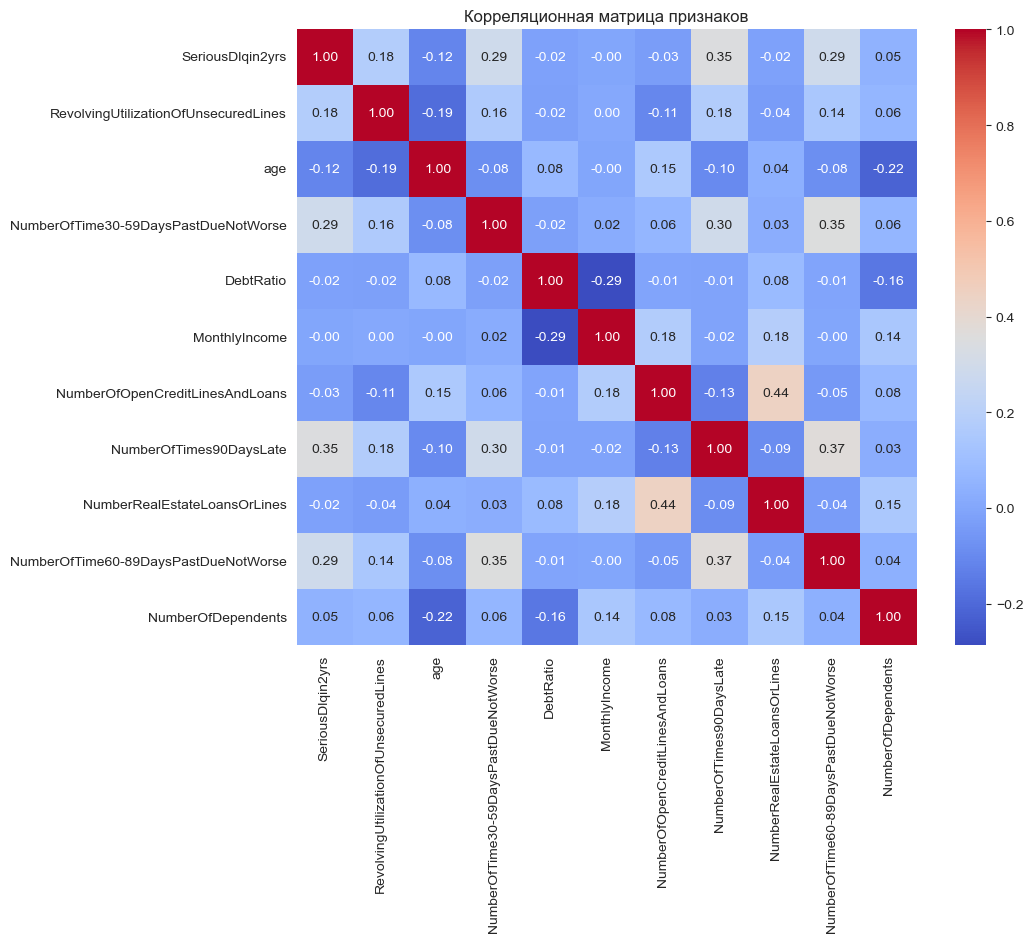

In [17]:
corr = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица признаков")
plt.show()

#### 1.4. Анализ целевой переменной

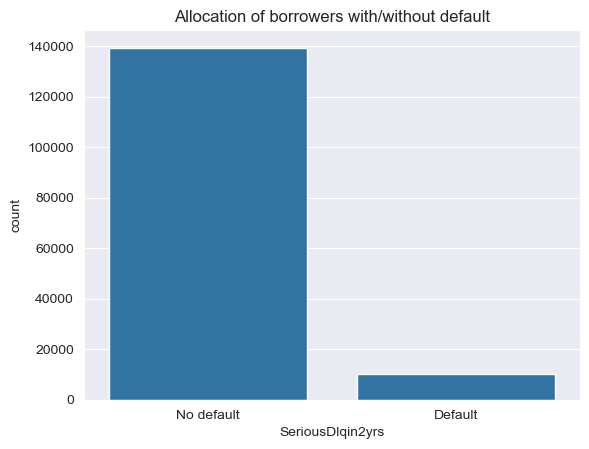

In [18]:
# Target variable analysis
sns.countplot(x='SeriousDlqin2yrs', data=train_df)
plt.title("Allocation of borrowers with/without default")
plt.xticks([0, 1], ['No default', 'Default'])
plt.show()

На этом графике видно явный дисбаланс классов: почти 140 000 записей без дефолта и всего около 10 000 — с дефолтом («плохих»). Если его не учесть, модель просто будет предсказывать «нет дефолта» и будут очень низкие ошибки на «большом» классе, но и бесполезность для задачи — ведь нас интересуют именно дефолты.

Как исправить?

1. **Стратифицированный сплит** - при разделении на train/test/val сохраняем пропорции дефолтов
2. **Resampling**  - Oversampling «плохого» класса, Undersampling «хорошего» класса
3. **Взвешивание классов**
4. **Метрики** - accuracy используем метрики, чувствительные к классовому дисбалансу (ROC AUC, Precision / Recall, F1-score, Precision–Recall AUC)


### 2. Построение и оценка модели

#### Разделение данных на train/validation/test

In [19]:
X = train_df.drop('SeriousDlqin2yrs', axis=1)
y = train_df['SeriousDlqin2yrs']

In [20]:
# Balancing classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("Before balancing:", y.value_counts())
print("After SMOTE:", pd.Series(y_balanced).value_counts())

Before balancing: SeriousDlqin2yrs
0    139382
1     10009
Name: count, dtype: int64
After SMOTE: SeriousDlqin2yrs
1    139382
0    139382
Name: count, dtype: int64


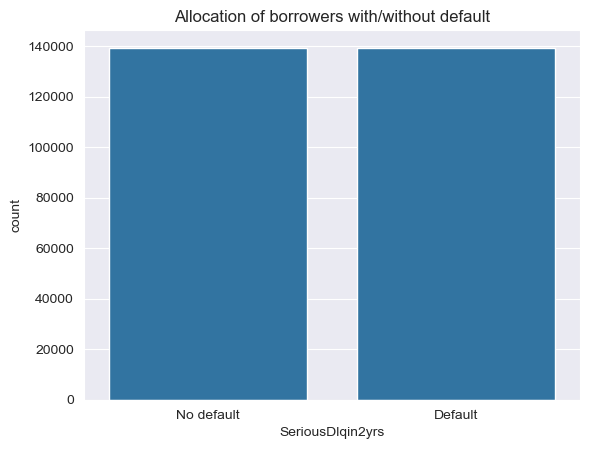

In [21]:
sns.countplot(x=y_balanced, data=X_balanced)
plt.title("Allocation of borrowers with/without default")
plt.xticks([0, 1], ['No default', 'Default'])
plt.show()

In [22]:
X_temp, X_test, y_temp, y_test = train_test_split(X_balanced, y_balanced, test_size=0.15, stratify=y_balanced,
                                                  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15 / 0.85, stratify=y_temp, random_state=42)

In [23]:
print(f"Train: {X_train.shape[0]} samples, "
      f"Val: {X_val.shape[0]} samples, "
      f"Test: {X_test.shape[0]} samples")

Train: 195134 samples, Val: 41815 samples, Test: 41815 samples


In [24]:
for name, y_ in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    prop = y_.mean()
    print(f"{name} default rate: {prop:.4f}")

Train default rate: 0.5000
Val default rate: 0.5000
Test default rate: 0.5000


#### Обучение модели

In [25]:
model = XGBClassifier(tree_method='hist')
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred, digits=3))
print('ROC AUC:', roc_auc_score(y_val, y_proba))

              precision    recall  f1-score   support

           0      0.835     0.835     0.835     20907
           1      0.835     0.835     0.835     20908

    accuracy                          0.835     41815
   macro avg      0.835     0.835     0.835     41815
weighted avg      0.835     0.835     0.835     41815

ROC AUC: 0.9219114526511585


In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        tree_method='hist',
        learning_rate=0.1,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train.values.ravel())
print("Best AUC: {:.4f}".format(grid_search.best_score_))
print("Best params:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best AUC: 0.9437
Best params: {'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}


#### Рассчет метрик: **AUC-ROC, Precision, Recall, F1-Score**

In [27]:
def metrics(model):
    for name, (X_, y_) in [('Train', (X_train, y_train)), ('Val', (X_val, y_val)), ('Test', (X_test, y_test))]:
        y_pred = model.predict(X_)
        y_proba = model.predict_proba(X_)[:, 1]
        print(f"\n--- XGBClassifier on {name} ---")
        print(classification_report(y_, y_pred, digits=3))
        print('ROC AUC:', roc_auc_score(y_, y_proba))

In [28]:
metrics(best_xgb)


--- XGBClassifier on Train ---
              precision    recall  f1-score   support

           0      0.915     0.911     0.913     97567
           1      0.911     0.915     0.913     97567

    accuracy                          0.913    195134
   macro avg      0.913     0.913     0.913    195134
weighted avg      0.913     0.913     0.913    195134

ROC AUC: 0.9756232194151961

--- XGBClassifier on Val ---
              precision    recall  f1-score   support

           0      0.866     0.857     0.862     20907
           1      0.859     0.868     0.863     20908

    accuracy                          0.862     41815
   macro avg      0.863     0.862     0.862     41815
weighted avg      0.863     0.862     0.862     41815

ROC AUC: 0.9435258094395627

--- XGBClassifier on Test ---
              precision    recall  f1-score   support

           0      0.870     0.856     0.863     20908
           1      0.858     0.872     0.865     20907

    accuracy                     

#### Проверка устойчивости модели

In [29]:
# Stability check via 5-fold Stratified K-Fold CV (according to AUC-ROC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_xgb, X_test, y_test, cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"5-Fold CV AUC-ROC scores: {cv_scores}")
print(f"Mean CV AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

5-Fold CV AUC-ROC scores: [0.91876873 0.92184132 0.91556626 0.9187456  0.92080689]
Mean CV AUC-ROC: 0.9191 ± 0.0022


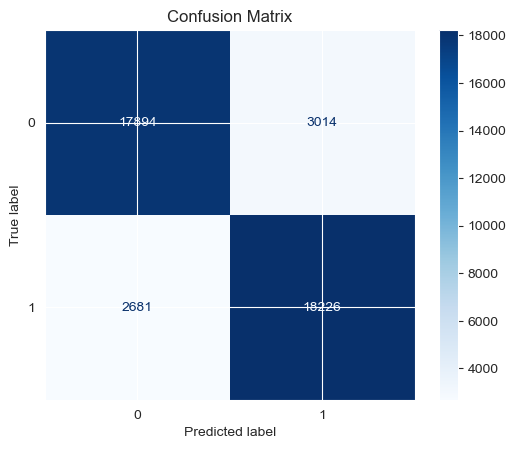

In [30]:
y_pred = best_xgb.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### 3. Интерпретация и этика

#### 3.1. Выделим **топ признаков**, влияющих на прогноз

In [31]:
n_samples = 10000

In [32]:
# Creating an explainer based on the training data and calculating the SHAP values for the test sample
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test.iloc[:n_samples])

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X_test.columns)

print("Top 10 features by the average absolute SHAP value:")
print(shap_importance.sort_values(ascending=False).head(10))

100%|===================| 9993/10000 [02:06<00:00]        

Top 10 features by the average absolute SHAP value:
NumberOfDependents                      1.523913
RevolvingUtilizationOfUnsecuredLines    0.906069
NumberRealEstateLoansOrLines            0.700185
DebtRatio                               0.641977
MonthlyIncome                           0.386103
NumberOfOpenCreditLinesAndLoans         0.349265
age                                     0.334949
NumberOfTimes90DaysLate                 0.322582
NumberOfTime30-59DaysPastDueNotWorse    0.310358
NumberOfTime60-89DaysPastDueNotWorse    0.092090
dtype: float64


In [33]:
# Creating an explainer based on the training data and calculating the LIME values for the test sample
def predict_fn(arr):
    return best_xgb.predict_proba(pd.DataFrame(arr, columns=X_test.columns))

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No default', 'Default'],
    mode='classification',
    discretize_continuous=False
)

weights = pd.DataFrame(0.0, index=range(n_samples // 10), columns=X_test.columns)

for i, idx in enumerate(np.random.choice(len(X_test), n_samples // 10, replace=False)):
    exp = explainer.explain_instance(
        data_row=X_test.values[idx],
        predict_fn=predict_fn,
        num_features=X_test.shape[1]
    )
    for feature_idx, weight in exp.as_map()[1]:
        weights.iat[i, feature_idx] = weight

print("Top 10 features by the average absolute LIME value:")
print(weights.abs().mean().nlargest(10))

Top 10 features by the average absolute LIME value:
NumberOfDependents                      0.159667
RevolvingUtilizationOfUnsecuredLines    0.065661
DebtRatio                               0.045364
NumberRealEstateLoansOrLines            0.033600
NumberOfOpenCreditLinesAndLoans         0.025582
age                                     0.019807
NumberOfTimes90DaysLate                 0.014338
NumberOfTime30-59DaysPastDueNotWorse    0.008356
MonthlyIncome                           0.005377
NumberOfTime60-89DaysPastDueNotWorse    0.003674
dtype: float64


Не трудно заметить что 4 основные признаки влияющие на прогноз

`NumberOfDependents`

`RevolvingUtilizationOfUnsecuredLines`

`NumberRealEstateLoansOrLines`

`DebtRatio`

Однако 5 признак вызывает вопросы, по SHAP `NumberOfOpenCreditLinesAndLoans` не сильно отстает от 2 фичей перед ним, но по LIME он оказывает более сильно влияние, поэтому 5 признак будет выбран `NumberOfOpenCreditLinesAndLoans`



#### 3.2. Проверка логичности влияния признаков

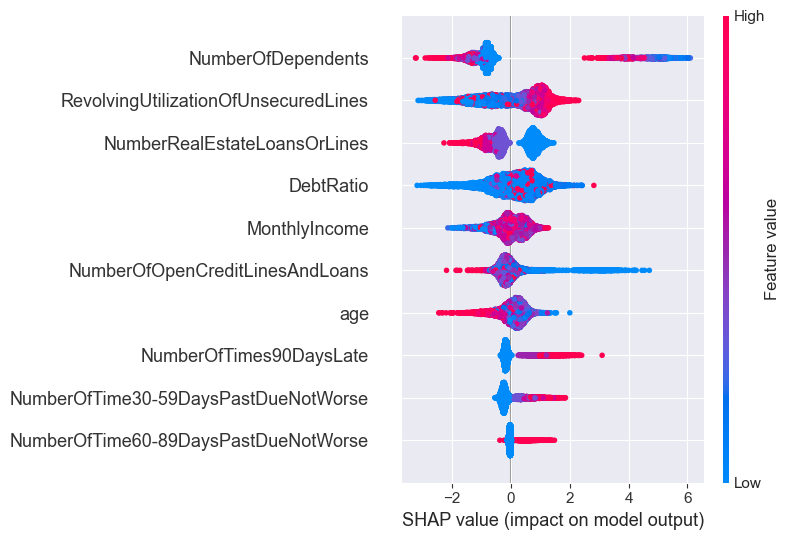

In [34]:
shap.summary_plot(shap_values, X_test.iloc[:n_samples], plot_type="dot", show=False)
plt.tight_layout()

1. **NumberOfDependents**

   * Высокие значения (розовые точки) сдвинуты вправо: большее количество иждивенцев повышает вероятность дефолта (положительный SHAP).
   * Низкие значения (синие) дают отрицательный вклад, то есть уменьшают вероятность дефолта.


2. **RevolvingUtilizationOfUnsecuredLines**

   * Чем выше коэффициент использования незабезпеченных лимитов (розовые), тем сильнее положительный вклад (увеличивает риск).
   * Низкие значения (синие) обычно дают отрицательный вклад — низкая нагрузка по кредитным линиям снижает риск.


3. **NumberRealEstateLoansOrLines**

   * Интересно: небольшое число (1–2) RealEstate займов/линий дает некоторый отрицательный вклад (снижение риска), а очень высокие значения (розовые справа) дают положительный вклад.
   * Видимо, наличие пары займов по недвижимости — это нормальная практика, но их избыток повышает нагрузку.


4. **DebtRatio**

   * При средних и низких значениях соотношения долга к доходу SHAP близок к нулю или отрицателен, но при очень высоких DebtRatio проявляется сильный положительный вклад, что логично: слишком большая доля долга повышает риск дефолта.


5. **NumberOfOpenCreditLinesAndLoans**

   * Небольшое число открытых кредитных линий даёт небольшой положительный вклад — возможно, недостаток кредитного опыта.
   * Очень много открытых счетов тоже даёт небольшой положительный вклад (чрезмерная активность по займам — риск).


---

**Экономическое обоснование**:

  * Чем выше доля долга (DebtRatio, RevolvingUtilization) и чем ниже доход, тем выше риск дефолта.
  * Наличие иждивенцев и большое число кредитов/займов увеличивают финансовую нагрузку.




#### 3.3. Оценка fairness модели: сравните метрики (FPR, TPR) для групп

In [35]:
def compute_rates(mask):
    y_pred = best_xgb.predict(X_test)[mask]
    y_true = y_test[mask]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # sensitivity / recall
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan  # fallout
    return tpr, fpr

In [36]:
def result(group):
    for name, mask in group.items():
        tpr, fpr = compute_rates(mask)
        print(f"{name}:")
        print(f"  TPR = {tpr:.3f}")
        print(f"  FPR = {fpr:.3f}\n")

In [37]:
result({
    'Young (<40)': X_test['age'] < 40,
    'Older (>=40)': X_test['age'] >= 40
})

Young (<40):
  TPR = 0.921
  FPR = 0.231

Older (>=40):
  TPR = 0.847
  FPR = 0.121



**Young (<40) vs Older (>=40)** Можно заметить разброс в работе модели между молодыми (<40) и взрослыми (≥40) клиентами:

* Разница в TPR (True Positive Rate) – модель на 7.4 % точнее ловит дефолты у молодых, чем у старших.
* Разница в FPR (False Positive Rate) – у молодых в 1.9 раза больше ложных срабатываний.

Вероятно, модель лучше выявляет характерные для молодых клиентов сигналы риска (более высокую долговую нагрузку и короткие дефолта), тогда как у старших эти признаки менее выражены, что и приводит к расхождению метрик.

In [38]:
result({
    'Income Low (<med)': X_test['MonthlyIncome'] < X_test['MonthlyIncome'].median(),
    'Income High (≥med)': X_test['MonthlyIncome'] >= X_test['MonthlyIncome'].median()
})

Income Low (<med):
  TPR = 0.900
  FPR = 0.195

Income High (≥med):
  TPR = 0.836
  FPR = 0.107



**Income Low (<med) vs Income High (≥med)** Можно заметить разброс между клиентами с доходом ниже медианы и не ниже медианы:

* Разница в TPR – модель на 6.4 % точнее ловит дефолты у группы с низким доходом.
* Разница в FPR – у группы с низким доходом в 1.8 раза больше ложных срабатываний.

Скорее всего, у клиентов с низким доходом признаки дефолта (очень высокая долговая нагрузка и нестабильность платежей) более явно выражены, из-за чего модель точнее их находит, но и чаще ошибается.

In [39]:
result({
    'No Dependents': X_test['NumberOfDependents'] == 0,
    'Has Dependents': X_test['NumberOfDependents'] > 0
})

No Dependents:
  TPR = 0.841
  FPR = 0.149

Has Dependents:
  TPR = 0.898
  FPR = 0.137



**No Dependents vs Has Dependents** Можно заметить разброс между клиентами без иждивенцев и с иждивенцами:

* Разница в TPR – модель на 5.7 % точнее ловит дефолты у тех, у кого есть иждивенцы.
* Разница в FPR – у клиентов без иждивенцев в 1.1 раза больше ложных срабатываний.

Клиенты с иждивенцами, вероятно, испытывают более предсказуемую финансовую нагрузку (дополнительные расходы), что делает их дефолты легче обнаруживаемыми и снижает число ошибочных «срабатываний» в этой группе.


In [40]:
result({
    'No RealEstate': X_test['NumberRealEstateLoansOrLines'] == 0,
    'Has RealEstate': X_test['NumberRealEstateLoansOrLines'] > 0
})

No RealEstate:
  TPR = 0.925
  FPR = 0.207

Has RealEstate:
  TPR = 0.812
  FPR = 0.109



**No RealEstate vs Has RealEstate** Можно заметить разброс между клиентами без и с ипотечными/земельными займами:

* Разница в TPR – модель на 11.3 % точнее ловит дефолты у тех, у кого нет недвижимости.
* Разница в FPR – у клиентов без недвижимости в 1.9 раза больше ложных срабатываний.

Наличие или отсутствие ипотечных обязательств существенно меняет профиль долговой нагрузки: без недвижимости доминируют краткосрочные кредиты с более предсказуемыми просрочками, тогда как у заемщиков с недвижимостью долгосрочные платежи менее однозначны для модели.

### 4. Отчет

#### Общие выводы по модели
* Финальная модель: XGBClassifier (max_depth=9, n_estimators=300, subsample=0.8)
* Лучшие метрики на test
    - ROC AUC: 0.944
    - Precision: 0.864
    - Recall: 0.864
    - F1-score: 0.864
* Кросс-валидация: Модель стабильна, по 5 folds разброс метрик невелик ROC AUC: 0.9191 ± 0.0022.

Модель XGBoost устойчиво показывает отличные метрики на тесте, что говорит о высокой способности выявлять дефолтных клиентов без значимого переобучения.

#### Ограничения
* Модель менее уверенно работает на “редких” профилях (много иждивенцев, нетипичный доход)
* Может занижать риски для молодых заемщиков или групп с мало представленными кейсами.
* Возможна переоценка “безопасности” клиентов, если их профиль близок к медианному.
* Пропуски в MonthlyIncome заменялись медианой — это могло снизить роль признака, если пропуск неслучаен.

#### Рекомендации по улучшению
* Добавить данные о кредитной истории, задолженностях в других банках, семейном положении.
* Применять более гибкие методы балансировки классов.
* Рассмотреть ансамблирование (смешивать XGB с CatBoost/логистической регрессией).
* Вести регулярный анализ fairness и explainability (SHAP/LIME) не только для глобальной, но и для локальной интерпретации.
* Следить за false positive/false negative для групп с высокой бизнес-стоимостью ошибки.

#### Сценарный анализ


In [41]:
def what_if(feat):
    profile = X.median().to_dict()
    values = np.arange(int(X[feat].min()), int(X[feat].max()) + 1)
    probas = []

    for val in values:
        sample = profile.copy()
        sample[feat] = val
        df_sample = pd.DataFrame([sample])
        probas.append(1 - best_xgb.predict_proba(df_sample)[0, 1])

    with plt.style.context("bmh"):
        fig, ax = plt.subplots()
        ax.plot(values, probas)
        ax.set(xlabel=feat, ylabel="The probability of default")
        plt.show()

Зафиксируем профиль "типичного" клиента (медианные значения признаков) и посмотрим влияние признаков

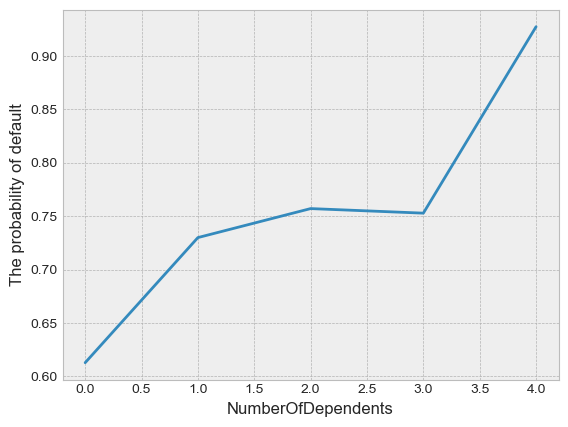

In [42]:
what_if('NumberOfDependents')

**Тенденция:**
С увеличением числа иждивенцев вероятность дефолта возрастает.

* При 0 иждивенцев вероятность около 0.60.
* При 4 иждивенцах вероятность достигает примерно 1.

**Вывод:**
Наличие большего количества иждивенцев коррелирует с повышенным финансовым риском, что отражается в росте вероятности дефолта.

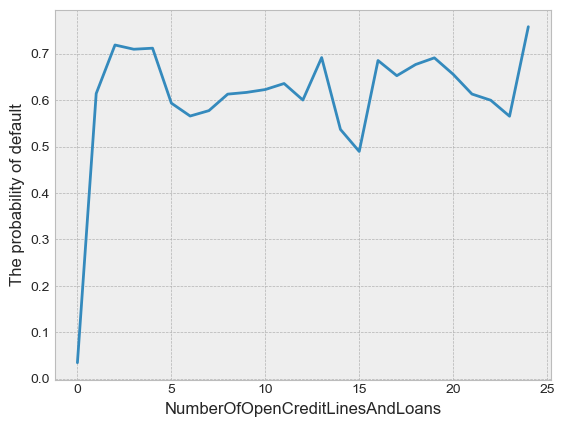

In [43]:
what_if('NumberOfOpenCreditLinesAndLoans')


**Тенденция:**
С увеличением количества открытых кредитных линий и займов (NumberOfOpenCreditLinesAndLoans) вероятность дефолта возрастает.
- При минимальном количестве кредитных линий вероятность дефолта составляет около **0.1**.
- При максимальном количестве кредитных линий вероятность увеличивается до **0.7**.
- Уже при начилии 1 кредитной линиии или займа верятность дефолта сильно растет

**Вывод:**
Чем больше у заемщика открытых кредитных линий и займов, тем выше вероятность дефолта. Это может быть связано с повышенной финансовой нагрузкой или снижением способности обслуживать дополнительные обязательства.

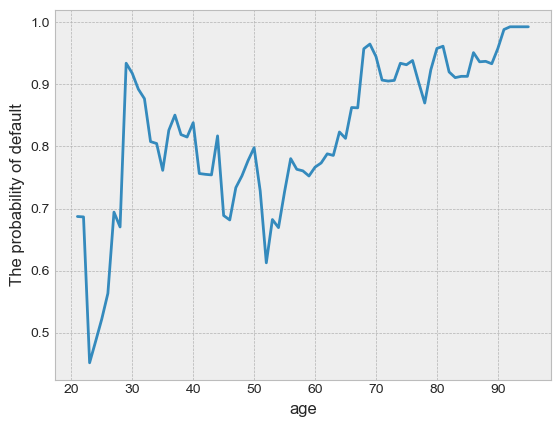

In [44]:
what_if('age')

**Тенденция:**
С увеличением возраста заемщика вероятность дефолта  постепенно снижается.
- В возрасте **20 лет** вероятность дефолта достигает **~1.0** (максимальный риск).
- В возрасте **90 лет** вероятность снижается до **~0.5** (вдвое меньше).

**Вывод:**
Молодые заемщики (20–30 лет) демонстрируют наиболее высокий риск дефолта, что может быть связано с нестабильным доходом, отсутствием кредитной истории или высокими расходами. С возрастом вероятность дефолта уменьшается, вероятно, благодаря финансовой стабильности и накопленному опыту управления долгами.

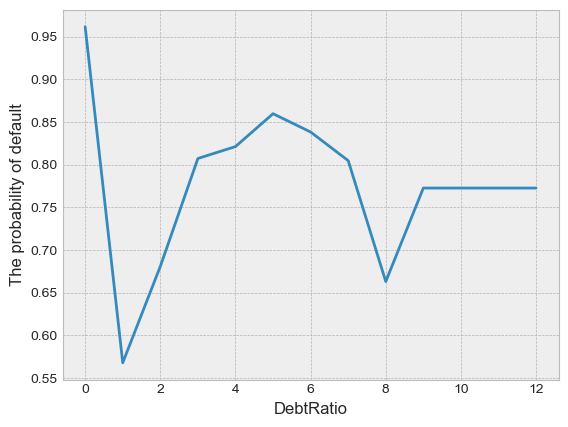

In [45]:
what_if('DebtRatio')

**Тенденция:**
С ростом коэффициента долговой нагрузки вероятность дефолта постепенно снижается
- При минимальном DebtRatio (близком к 0) вероятность дефолта максимальна — **~0.95**
- Обратная зависимость: В отличие от типичных ожиданий, более высокий DebtRatio коррелирует с меньшей вероятностью дефолта.
- Наиболее резкое падение риска происходит на участке от 0 до 4 по шкале DebtRatio.

**Вывод:**
Традиционная логика "чем больше долг — тем выше риск" здесь не работает.


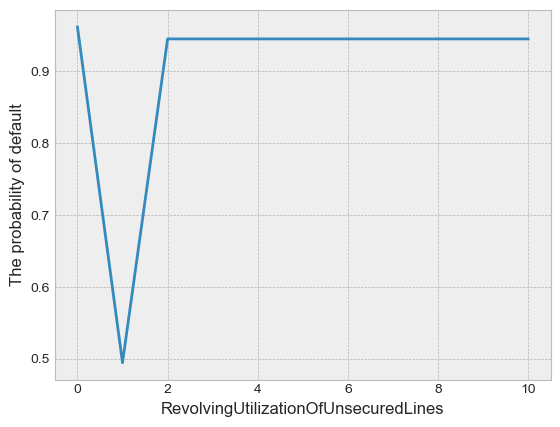

In [46]:
what_if('RevolvingUtilizationOfUnsecuredLines')

**Тенденция:**
С ростом уровня использования необеспеченных кредитных линий вероятность дефолта существенно возрастает:
- Уже небольшое увеличение загрузки кредитных линий приводит к резкому скачку вероятности дефолта.
- Использование более 2 необеспеченных линий стабильно держит вероятность дефолта выше 0.8.
- Даже минимальное использование кредитов является сильным индикатором финансовой нестабильности.
- Значения выше 4 следует рассматривать как "красную зону" при оценке кредитоспособности.